In [16]:
#### from pyWinSpec.winspec import SpeFile
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.constants import h, c, k
from scipy.optimize import curve_fit
import re
import datetime

class TempErrAnalysis:
    def __init__(self, file_paths_upstr, file_paths_dwstr):
        #calibrationファイルからフィッティングをして温度のdistributionを生成する
        self.file_paths_upstr = file_paths_upstr
        self.file_paths_dwstr = file_paths_dwstr
        self.calc_Terr_total(self.file_paths_upstr, self.file_paths_dwstr)
        #出てきた温度のdistributionから1ランの温度と温度誤差を計算する
        #温度の計算をfor文で回して時間的な温度誤差も計算し、実験温度とその誤差を算出する。
        

    def planck_function(self, wavelengths, temperature, scale):
        # 波長をメートルに変換 (nm -> m)
        wavelengths_m = np.array(wavelengths) * 1e-9

        # プランク関数の計算
        intensity = (2.0 * h * c**2) / (wavelengths_m**5) / (np.exp((h * c) / (wavelengths_m * k * temperature)) - 1.0)

        return scale * intensity
    

    def planck_fit(self, wavelengths, intensities):
        # フィッティング関数
        def fitting_func(wavelengths, temperature, scale):
            return self.planck_function(wavelengths, temperature, scale)

        initial_guess = [5000, 1e-9]  # 温度とスケールファクタの初期推定値
        
        try:
            # curve_fitでフィッティング、maxfevを増やして最大関数評価回数を設定
            popt, pcov = curve_fit(fitting_func, wavelengths, intensities, p0=initial_guess, maxfev=10000)

            # フィッティングされた温度とスケールファクタ、不確かさを返す
            T = popt[0]
            scale = popt[1]
            T_err = np.sqrt(pcov[0, 0])
            scale_err = np.sqrt(pcov[1, 1])

            # フィッティングされた温度を返す
            return [T, scale, T_err, scale_err]
        except RuntimeError:
            # フィッティングが収束しなかった場合
            return [0, 0, 0, 0]
    
    
    def set_calibfile_name(self, calibfile_path):
        calibfile = SpeFile(calibfile_path)
        calibfile_basename = os.path.basename(calibfile)
        calibfile_name = os.path.splitext(file_name)[0]
        return calibfile_name
    
    def import_spefile(self, calibfile_path):
        # calibフォルダをSPEフォルダに置換
        spefile_directory = calibfile_path.replace("/calib/", "/SPE/")
        # calibを取り除いたファイル名を生成
        spefile_name = spefile_directory.replace("_calib", "")
        spefile_name = spefile_name.replace("rotated_", "")
        spefile_name = spefile_name.replace("/bef", "")
        spefile_name = spefile_name.replace("/aft", "")
        spefile = SpeFile(spefile_name)
        return spefile
    
    def get_df_spe(self, calibfile_path):
        spefile = self.import_spefile(calibfile_path)
        data_2d = np.squeeze(spefile.data)
        spe_intensity = pd.DataFrame(data_2d)
        return spe_intensity

    
    def extract_number(self, filename):
        match = re.search(r'(\d+)\.spe$', filename)
        if match:
            return int(match.group(1))
        return float('inf')  # 数字が見つからない場合は無限大として扱う
    
    def get_datetime(self, calibfile_path):
        spe_file = self.import_spefile(calibfile_path)
        datetime = spe_file.date_time
        return datetime
    
    
    def get_heatingtime(self, datetime_list):
        # 最初のdatetimeを基準とする
        base_time = datetime_list[0]
        # heatingtime_listに差分を格納
        heatingtime_list = [(dt - base_time) for dt in datetime_list]
        heatingtime_min = [ht.total_seconds() / 60 for ht in heatingtime_list]

        return heatingtime_min
    

    def calc_calc_range(self, direction):
        if direction == 'up':
            calc_range = list(range(200))
        elif direction == 'dw':
            calc_range = list(range(200, 400))
        else:
            raise ValueError("方向は 'up' か 'dw' のどちらかでなければなりません。")
        return calc_range
        
    def get_center_column(self, direction, calibfile_path):
        data = self.get_df_spe(calibfile_path)
        intensity_sum = data.sum()
        pixel_position_up = np.argmax(intensity_sum[0:200])
        pixel_position_dw = np.argmax(intensity_sum[200:400])
        if direction == 'up':
            center_pixel = pixel_position_up
        elif direction == 'dw':
            center_pixel = pixel_position_dw
        return center_pixel
        

    def calc_temp_dist(self, direction, intensity_sum, threshold, wl_arr, spectrum_arr):
        pixel_indices = []
        T_dist = []
                
#        window = [295, 556] # 550~650 nmの波長に対応
#         window = [425, 950] # 600~800 nmの波長に対   
        window = [295, 700] # 550~700 nmの波長に対応
#         window = [350, 700] # 570~700 nmの波長に対応
#         window = [350, 650] # 570~685 nmの波長に対応
        calc_range = self.calc_calc_range(direction)
        for pixel in tqdm(calc_range):
            if intensity_sum[pixel]  > threshold:
                wls = wl_arr[window[0]:window[1]]
                spectrum = spectrum_arr[window[0]:window[1], pixel]
                # upstream温度の計算
                results = self.planck_fit(wls, spectrum)
                T = results[0]
                
                if T is not None and T < 3000:
                    T_dist.append(T)
                    pixel_indices.append(pixel)
                else:
                    T_dist.append(None)
            else:
                T_dist.append(300)
            
        return T_dist, pixel_indices
        
        
    def calc_Terr_spatial(self, calibfile_path, T_dist, pixel_indices, direction):
        # 追加されたピクセルの中央3ピクセル分の平均と標準偏差の2倍を計算
        spatial_T = None
        spatial_Terr = None
        n_center = None
        
        dist_len = len(pixel_indices)
        
        center_pixel = self.get_center_column(direction, calibfile_path)
        
        if dist_len < 4:
            spatial_T = 0
            spatial_Terr = 0
        elif dist_len >= 4:
            n_center = center_pixel
            
        if n_center is None:
            spatial_T = 0
            spatial_Terr = 0
        else:
            spatial_T_list = [T_dist[center_pixel-1], T_dist[center_pixel], T_dist[center_pixel+1]]

            spatial_T = np.mean(spatial_T_list)
            spatial_T_std = np.std(spatial_T_list)
            spatial_Terr = spatial_T_std            
                
        return spatial_T, spatial_Terr
    
    
    def calc_threshold(self, direction, mag_threshold, intensity_sum):
        calc_range = self.calc_calc_range(direction)
            
        peak_max = intensity_sum[calc_range].max()
        peak_min = intensity_sum[calc_range].min()
        peak_len = peak_max - peak_min
        threshold = peak_len*mag_threshold + peak_min
        
        return threshold
    
    
    def calc_Terr(self, T_list, Terr_list):
        filtered_T_list = [T for T in T_list if T != 0]
        filtered_Terr_list = [Terr for Terr in Terr_list if Terr != 0]
        T_ave =  np.average(np.array(filtered_T_list))
        T_std = np.std(np.array(filtered_T_list))
        Terr_temporal = 2 * T_std
        Terr_spatial = np.average(np.array(filtered_Terr_list))
        Terr = (Terr_temporal + Terr_spatial)
        Terr_percent = Terr / T_ave * 100
        return T_ave, Terr, Terr_percent
    
    def average_list(self, listtype, upstr_list, dwstr_list):
        ave_list = []
        for upstr, dwstr in zip(upstr_list, dwstr_list):
            if upstr != 0 and dwstr != 0:
                if listtype == 'T':
                    ave_list.append((upstr + dwstr) / 2)
                elif listtype == 'Terr':
                    ave_list.append((upstr**2 + dwstr**2)**(1/2))
            elif upstr == 0 and dwstr == 0:
                ave_list.append(0)
            elif upstr == 0 and dwstr != 0:
                ave_list.append(dwstr)
            elif dwstr == 0 and upstr != 0:
                ave_list.append(upstr)
        return ave_list
    
    
    def plot_Tdist(self, T_dist):
        fig, ax = plt.subplots()
        ax.plot(T_dist)

        # x軸の範囲を指定（例として0から10に設定）
        ax.set_xlim(124, 130)

        ax.set_xlabel('pixel', fontsize=15)  # 必要に応じてラベルを設定
        ax.set_ylabel('Temperature (K)', fontsize=15)

        current_date = datetime.date.today()
        date_str = current_date.strftime("%Y%m%d")  # この場合、形式は"YYYYMMDD"です
        filename = f"./pdf/Temp/distribution_{date_str}.pdf"
        plt.savefig(filename, format='pdf')

        plt.show()

    

    def calc_Terr_total(self, file_paths_upstr, file_paths_dwstr):
        files_upstr = os.listdir(self.file_paths_upstr)
        files_dwstr = os.listdir(self.file_paths_dwstr)
        directions = ['up', 'dw']
        
        for direction in directions:
            if direction == 'up':
                files = files_upstr
                file_paths = self.file_paths_upstr
            elif direction == 'dw':
                files = files_dwstr
                file_paths = self.file_paths_dwstr
                
            T_list = []
            Terr_list = []
            datetime_list = []
            heattime_list = []
            
            # ファイル名を末尾の数字でソート
            sorted_files = sorted(files, key=self.extract_number)
            for file in sorted_files:
                # Calibration fileについての各種設定
                print(file)
                calibfile_path = os.path.join(file_paths, file)
                calibfile = SpeFile(calibfile_path)                                   # ファイルを読み込む
                wl_arr = calibfile.xaxis                                                     # 波長のアレイの定義
                spectrum_arr = np.squeeze(calibfile.data)
                calibfile_df = pd.DataFrame(spectrum_arr)         # calibrationファイルのデータをdf化
                # SPE fileについての各種設定
                df_spe = self.get_df_spe(calibfile_path)
                calc_range = self.calc_calc_range(direction)
                intensity_sum = df_spe.sum()
                intensity_sum_max = intensity_sum[calc_range].max()
                if direction == 'dw':
                    datetime = self.get_datetime(calibfile_path)
                    datetime_list.append(datetime)
                else:
                    pass

                
                if intensity_sum_max < 30000:
                    T_list.append(0)
                    Terr_list.append(0)
                else:
                    #thresholdの計算(direction, mag_threshold, intensity_sum)
                    mag_threshold = 0.4
                    intensity_sum = calibfile_df.sum()
                    threshold = self.calc_threshold(direction, mag_threshold, intensity_sum)

                    #distributionの計算(direction, intensity_sum, threshold, wl_arr, spectrum_arr)
                    T_dist, pixel_indices = self.calc_temp_dist(direction, intensity_sum, threshold, wl_arr, spectrum_arr)
#                     if file == 'T1_34_calib.SPE':
#                         Tdist_plot = self.plot_Tdist(T_dist)

                    #T, Terrの計算(T_list, pixel_indices)
                    T, Terr = self.calc_Terr_spatial(calibfile_path, T_dist, pixel_indices, direction)
                    #リストに追加
                    T_list.append(T)
                    Terr_list.append(Terr)
                
                print(direction, file, T)
                
            if direction == 'up':
                self.T_upstr_list = T_list
                self.Terr_upstr_list = Terr_list
            elif direction == 'dw':
                self.T_dwstr_list = T_list
                self.Terr_dwstr_list = Terr_list
                
                
        # heating timeの定義
        heatingtime_list = self.get_heatingtime(datetime_list)

        # 実験の温度誤差の計算(T_list, Terr_list)
        T_ave_upstr, Terr_upstr, Terr_percent_upstr = self.calc_Terr(self.T_upstr_list, self.Terr_upstr_list)
        print(f'上流の温度：{T_ave_upstr:.0f} K, 上流の温度誤差：{Terr_upstr:.0f}K ({Terr_percent_upstr}%)')
        T_ave_dwstr, Terr_dwstr, Terr_percent_dwstr = self.calc_Terr(self.T_dwstr_list, self.Terr_dwstr_list)
        print(f'下流の温度：{T_ave_dwstr:.0f} K, 下流の温度誤差：{Terr_dwstr:.0f}K ({Terr_percent_dwstr}%)')

        # 全体の温度とその誤差
        T_ave_list =  self.average_list('T', self.T_upstr_list, self.T_dwstr_list)
        Terr_ave_list = self.average_list('Terr', self.Terr_upstr_list, self.Terr_dwstr_list)
        T_ave, Terr_ave, Terr_percent_ave = self.calc_Terr(T_ave_list, Terr_ave_list)
        print(f'平均温度：{T_ave:.0f}K, 平均温度誤差：{Terr_ave:.0f}K ({Terr_percent_ave:.0f}%)')

        plt.figure(figsize=(10, 6))
        plt.errorbar(heatingtime_list, self.T_upstr_list, yerr=self.Terr_upstr_list, fmt='o', color='red', ecolor='gray', capsize=0, label='T_upstr')
        plt.errorbar(heatingtime_list, self.T_dwstr_list, yerr=self.Terr_dwstr_list, fmt='s', color='blue', ecolor='gray', capsize=0, label='T_dwstr')
        plt.errorbar(heatingtime_list, T_ave_list, yerr=Terr_ave_list, fmt='s', color='black', ecolor='black', capsize=0, label='T_average')
        plt.legend()
#         ylim = T_ave_dwstr * 0.1
#         plt.ylim([T_ave_dwstr - ylim, T_ave_dwstr + ylim])
        plt.ylim(0,2500)
        plt.xlabel('Heating time (minutes)', fontsize=15)
        plt.ylabel('Temperature (K)', fontsize=15)
        #保存
        current_date = datetime.today().date()
        date_str = current_date.strftime("%Y%m%d")  # この場合、形式は"YYYYMMDD"です
        filename = f"./pdf/Temp/heating stability_{date_str}.pdf"
        plt.savefig(filename, format='pdf')
        plt.show()

MHIH2113_19_calib.SPE


100%|███████████████████████████████████████| 200/200 [00:00<00:00, 1714.91it/s]


up MHIH2113_19_calib.SPE 1729.694040462524
MHIH2113_20_calib.SPE


  0%|                                                   | 0/200 [00:00<?, ?it/s]/var/folders/yl/hcd4s5l15wx6rpkzyssk4rc40000gn/T/ipykernel_53620/365275849.py:27: RuntimeWarning: overflow encountered in exp
  intensity = (2.0 * h * c**2) / (wavelengths_m**5) / (np.exp((h * c) / (wavelengths_m * k * temperature)) - 1.0)
100%|███████████████████████████████████████| 200/200 [00:00<00:00, 2011.61it/s]


up MHIH2113_20_calib.SPE 1728.8242190657622
MHIH2113_21_calib.SPE


100%|███████████████████████████████████████| 200/200 [00:00<00:00, 1663.29it/s]


up MHIH2113_21_calib.SPE 1727.2892327811587
MHIH2113_22_calib.SPE


100%|███████████████████████████████████████| 200/200 [00:00<00:00, 1953.89it/s]


up MHIH2113_22_calib.SPE 1732.5751222999945
MHIH2113_23_calib.SPE


100%|███████████████████████████████████████| 200/200 [00:00<00:00, 1548.25it/s]


up MHIH2113_23_calib.SPE 1733.0948095508775
MHIH2113_24_calib.SPE


100%|███████████████████████████████████████| 200/200 [00:00<00:00, 2530.85it/s]


up MHIH2113_24_calib.SPE 1726.7319355424913
MHIH2113_26_calib.SPE


100%|███████████████████████████████████████| 200/200 [00:00<00:00, 1574.70it/s]


up MHIH2113_26_calib.SPE 1736.890978387438
MHIH2113_27_calib.SPE


100%|███████████████████████████████████████| 200/200 [00:00<00:00, 1259.38it/s]


up MHIH2113_27_calib.SPE 1742.9242054047766
MHIH2113_28_calib.SPE


100%|███████████████████████████████████████| 200/200 [00:00<00:00, 1824.30it/s]


up MHIH2113_28_calib.SPE 1743.560647759916
MHIH2113_29_calib.SPE


100%|███████████████████████████████████████| 200/200 [00:00<00:00, 2255.12it/s]


up MHIH2113_29_calib.SPE 1745.7931351953848
MHIH2113_30_calib.SPE


100%|███████████████████████████████████████| 200/200 [00:00<00:00, 1652.02it/s]


up MHIH2113_30_calib.SPE 1750.7157379867933
MHIH2113_32_calib.SPE


100%|███████████████████████████████████████| 200/200 [00:00<00:00, 1051.54it/s]


up MHIH2113_32_calib.SPE 1818.4394832093956
MHIH2113_33_calib.SPE


100%|███████████████████████████████████████| 200/200 [00:00<00:00, 1381.94it/s]


up MHIH2113_33_calib.SPE 1833.8133562340074
MHIH2113_34_calib.SPE


  0%|                                                   | 0/200 [00:00<?, ?it/s]/var/folders/yl/hcd4s5l15wx6rpkzyssk4rc40000gn/T/ipykernel_53620/365275849.py:27: RuntimeWarning: overflow encountered in exp
  intensity = (2.0 * h * c**2) / (wavelengths_m**5) / (np.exp((h * c) / (wavelengths_m * k * temperature)) - 1.0)
100%|███████████████████████████████████████| 200/200 [00:00<00:00, 2472.16it/s]


up MHIH2113_34_calib.SPE 1849.241899381347
MHIH2113_35_calib.SPE


100%|███████████████████████████████████████| 200/200 [00:00<00:00, 2638.67it/s]


up MHIH2113_35_calib.SPE 1858.5841437743275
MHIH2113_19_calib.SPE


100%|███████████████████████████████████████| 200/200 [00:00<00:00, 2198.89it/s]


dw MHIH2113_19_calib.SPE 1658.3728043549102
MHIH2113_20_calib.SPE


100%|███████████████████████████████████████| 200/200 [00:00<00:00, 2132.56it/s]


dw MHIH2113_20_calib.SPE 1654.6005548896565
MHIH2113_21_calib.SPE


100%|███████████████████████████████████████| 200/200 [00:00<00:00, 1580.63it/s]


dw MHIH2113_21_calib.SPE 1657.033573398563
MHIH2113_22_calib.SPE


100%|███████████████████████████████████████| 200/200 [00:00<00:00, 3049.85it/s]


dw MHIH2113_22_calib.SPE 1626.5054973889373
MHIH2113_23_calib.SPE


100%|███████████████████████████████████████| 200/200 [00:00<00:00, 2521.69it/s]


dw MHIH2113_23_calib.SPE 1626.4206381434149
MHIH2113_24_calib.SPE


100%|███████████████████████████████████████| 200/200 [00:00<00:00, 2848.59it/s]


dw MHIH2113_24_calib.SPE 1632.1542809309237
MHIH2113_26_calib.SPE


100%|███████████████████████████████████████| 200/200 [00:00<00:00, 2997.91it/s]


dw MHIH2113_26_calib.SPE 1637.0750417172756
MHIH2113_27_calib.SPE


100%|███████████████████████████████████████| 200/200 [00:00<00:00, 3095.45it/s]


dw MHIH2113_27_calib.SPE 1658.7172436610244
MHIH2113_28_calib.SPE


100%|███████████████████████████████████████| 200/200 [00:00<00:00, 1857.62it/s]


dw MHIH2113_28_calib.SPE 1674.4692770806694
MHIH2113_29_calib.SPE


100%|███████████████████████████████████████| 200/200 [00:00<00:00, 3566.96it/s]


dw MHIH2113_29_calib.SPE 1690.7674924707583
MHIH2113_30_calib.SPE


100%|███████████████████████████████████████| 200/200 [00:00<00:00, 3634.91it/s]

dw MHIH2113_30_calib.SPE 1716.3676624967102
MHIH2113_32_calib.SPE



100%|███████████████████████████████████████| 200/200 [00:00<00:00, 2456.18it/s]


dw MHIH2113_32_calib.SPE 1765.3896168921285
MHIH2113_33_calib.SPE


100%|███████████████████████████████████████| 200/200 [00:00<00:00, 2702.01it/s]


dw MHIH2113_33_calib.SPE 1788.428029139365
MHIH2113_34_calib.SPE


100%|███████████████████████████████████████| 200/200 [00:00<00:00, 2951.78it/s]


dw MHIH2113_34_calib.SPE 1805.6451792701248
MHIH2113_35_calib.SPE


  0%|                                                   | 0/200 [00:00<?, ?it/s]/var/folders/yl/hcd4s5l15wx6rpkzyssk4rc40000gn/T/ipykernel_53620/365275849.py:27: RuntimeWarning: overflow encountered in exp
  intensity = (2.0 * h * c**2) / (wavelengths_m**5) / (np.exp((h * c) / (wavelengths_m * k * temperature)) - 1.0)
100%|███████████████████████████████████████| 200/200 [00:00<00:00, 3284.18it/s]


dw MHIH2113_35_calib.SPE 1812.4654858337442
上流の温度：1764 K, 上流の温度誤差：120K (6.799407736981718%)
下流の温度：1694 K, 下流の温度誤差：137K (8.11590314416971%)
平均温度：1729K, 平均温度誤差：138K (8%)


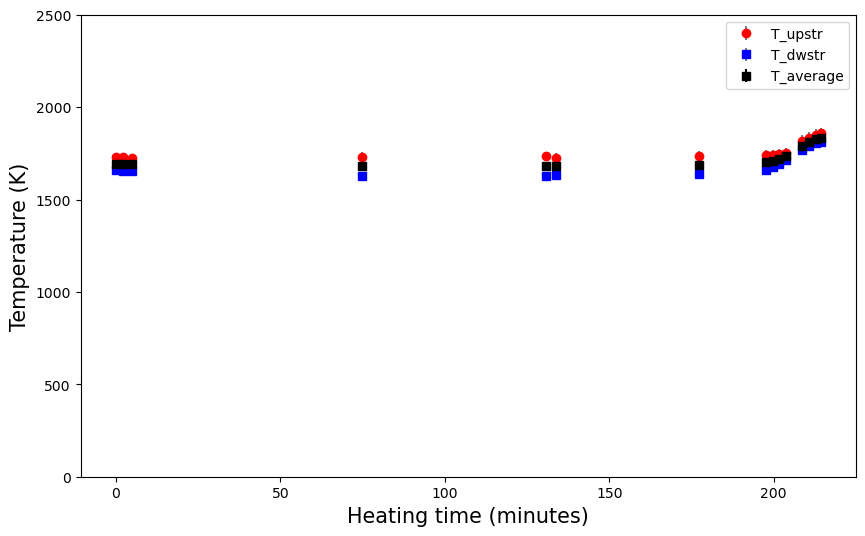

In [19]:
from pyWinSpec.winspec import SpeFile
file_paths_upstr = '/Volumes/Ohta_ssd/Nagaya/IXS/2107/MHIH2113_T/calib/2000K'
file_paths_dwstr = '/Volumes/Ohta_ssd/Nagaya/IXS/2107/MHIH2113_T/calib/2000K'
temp = TempErrAnalysis(file_paths_upstr, file_paths_dwstr)

In [1]:
from pyWinSpec.winspec import SpeFile
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
file_path = '/Users/nagayayoshihiro/project/IXS/IXS_Fe/rawdata/US_6.5A_0.05s74-76pixel2.SPE'
spe_file = SpeFile(file_path)
# file_paths_2 = '/Users/nagayayoshihiro/project/IXS/IXS_Fe/rawdata/Kurochan2nd_T/calib/test'
# temp = TempErrAnalysis(file_paths_2)
# spe_file = SpeFile('/Users/nagayayoshihiro/project/IXS/IXS_Fe/rawdata/Kurochan2nd_T/Kurochan23Oct10_26_calib_distribution.SPE')
# spe_file = SpeFile('/Users/nagayayoshihiro/project/IXS/IXS_Fe/rawdata/Kurochan2nd_T/Kurochan23Oct10_63.SPE')

In [11]:
#ファイル名を設定する
dir_parts = file_path.split('/')
part1 = dir_parts[-4]  # "Ohta06_180GPa" 部分を取得
file_name = os.path.basename(file_path)  # "T1_27_calib.SPE"
part2 = os.path.splitext(file_name)[0]  # "T1_27_calib" の部分を取得
# "_" で結合して新しいファイル名を作成
file_name = f"{part1}_{part2}"
print(file_name)  # Ohta06_180GPa_T1_27_calib

IXS_US_6.5A_0.05s74-76pixel2


In [12]:
#dataの定義
spe_data = spe_file.data
data_2d = np.squeeze(spe_data)
data = pd.DataFrame(data_2d)
print(data.shape)

(1340, 1)


In [13]:
def calc_Terr(T_list, Terr_list):
    filtered_T_list = [T for T in T_list if T != 0]
    filtered_Terr_list = [Terr for Terr in Terr_list if Terr != 0]
    T_ave =  np.average(np.array(filtered_T_list))
    T_std = np.std(np.array(filtered_T_list))
    Terr_temporal = 2 * T_std
    Terr_spatial = np.average(np.array(filtered_Terr_list))
    Terr = (Terr_temporal**2 + Terr_spatial**2)**(1/2)
    Terr_percent = Terr / T_ave * 100
    return T_ave, Terr, Terr_percent

from scipy.constants import h, c, k
from scipy.optimize import curve_fit

def planck_function(wavelengths, temperature, scale):
    # 波長をメートルに変換 (nm -> m)
    wavelengths_m = np.array(wavelengths) * 1e-9

    # プランク関数の計算
    intensity = (2.0 * h * c**2) / (wavelengths_m**5) / (np.exp((h * c) / (wavelengths_m * k * temperature)) - 1.0)

    return scale * intensity

def planck_fit(wavelengths, intensities):
    # フィッティング関数
    def fitting_func(wavelengths, temperature, scale):
        return planck_function(wavelengths, temperature, scale)
    
    initial_guess = [5000, 1e-9]  # 温度とスケールファクタの初期推定値
    
    # curve_fitでフィッティング
    popt, pcov = curve_fit(fitting_func, wavelengths, intensities, p0=initial_guess)
    
    # フィッティングされた温度とスケールファクタ、不確かさを返す
    T = popt[0]
    scale = popt[1]
    T_err = np.sqrt(pcov[0, 0])
    scale_err = np.sqrt(pcov[1, 1])
    
    # フィッティングされた温度を返す
    return [T, scale, T_err, scale_err]

In [5]:
print(dir(spe_file))
print(spe_file.date_time)
print(spe_file.filename)
print(spe_file.exposure_time)
print(spe_file.data.shape)
print(spe_file.x_calibration)

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_data', '_data_type', '_datatype_map', '_fid', '_make_axes', '_num_combined_frames', '_read', '_read_at', '_read_calibration_from_header', '_read_center_wavelength_from_header', '_read_datatype', '_read_date_time_from_header', '_read_detector_from_header', '_read_exposure_from_header', '_read_frame', '_read_grating_from_header', '_read_img', '_read_num_combined_frames_from_header', '_read_num_frames_from_header', '_read_parameter', '_read_parameter_from_dom', '_read_parameter_from_header', '_read_roi_from_dom', '_read_roi_from_header', '_read_size', '_xaxis', '_xdim', '_yaxis', '_ydim', 'adc', 'adc_rate', 'center_wavelength', 'data', 'date_time',

570.896094880366 685.7675238881426


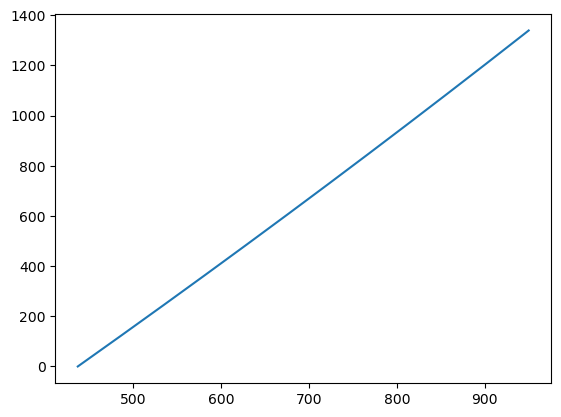

In [6]:
# print(spe_file.data.shape)


# print(spe_file.xaxis)
wavelength = spe_file.xaxis
# print(spe_file.xaxis.max(), spe_file.xaxis.min())

data_x = range(1340)
plt.plot(spe_file.xaxis, data_x)

def pixel_to_wavelength(pixel): 
    slope = (spe_file.xaxis.max() - spe_file.xaxis.min()) / 1340
    wavelength = slope * pixel + spe_file.xaxis.min()
    return wavelength

y_min = pixel_to_wavelength(350)
y_max = pixel_to_wavelength(650)
print(y_min, y_max)


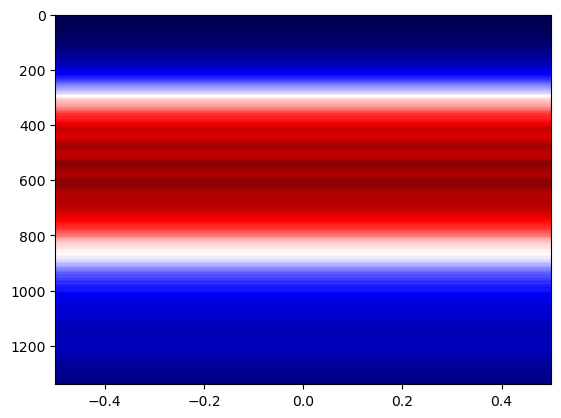

In [10]:
import matplotlib.pyplot as plt
plt.imshow(data, aspect='auto', cmap = 'seismic')

In [8]:
data.columns
plt.plot(data[320])

KeyError: 320

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# 仮のデータを生成（実際のデータを使用してください）
# data = pd.DataFrame(np.random.random((縦軸の長さ, 横軸の長さ)))

# 横軸の範囲を設定
x_max = data.shape[1]
y_max = data.shape[0]
y_range = range(1340)


# 各列の最大値を求める
max_values_up = data.iloc[:, :201].max(axis=1).values
max_posi_up = data.iloc[:, :201].idxmax(axis=1).values
max_values_dw = data.iloc[:, 201:].max(axis=1).values
max_posi_dw = data.iloc[:, 201:].idxmax(axis=1).values

# 線形関数を定義
def linear_func(x, a, b):
    return a * x + b

# 600番目から800番目のインデックス範囲を設定
index_range = np.arange(425, 900)
# その範囲でのフィッティングデータを取得
y_range_subset = np.array(y_range)[index_range]
max_posi_up_subset = max_posi_up[index_range]
max_posi_dw_subset = max_posi_dw[index_range]

# 線形フィットを実行
popt_up, _ = curve_fit(linear_func, y_range_subset, max_posi_up_subset)
popt_dw, _ = curve_fit(linear_func, y_range_subset, max_posi_dw_subset)


# 傾きを取得
slope_up = popt_up[0]
slope_dw = popt_dw[0]

angle_up = np.degrees(np.arctan(slope_up))
angle_dw = np.degrees(np.arctan(slope_dw))

# 結果をプロット
plt.figure()
plt.imshow(data.values, aspect='auto', cmap='seismic')
# max_valuesをプロットし、元の画像に重ねる
plt.plot(max_posi_up, y_range, color='yellow', marker='o', linestyle='None', label='Max Values', markersize=0.5)
plt.plot(max_posi_dw, y_range, color='yellow', marker='o', linestyle='None', label='Max Values', markersize=0.5)
# plt.plot(linear_func(y_range, *popt_up), y_range, color='yellow', label=f'Slope: {slope_up:.2f}')
# plt.plot(linear_func(y_range, *popt_dw), y_range, color='yellow', label=f'Slope: {slope_dw:.2f}')
# plt.legend()
plt.show()

# 傾きを出力
print(f"傾き: {angle_up:.4f} 度")
print(f"傾き: {angle_dw:.4f} 度")


ValueError: attempt to get argmax of an empty sequence

The max intensity position (up): 70
The max intensity position (dw): 322


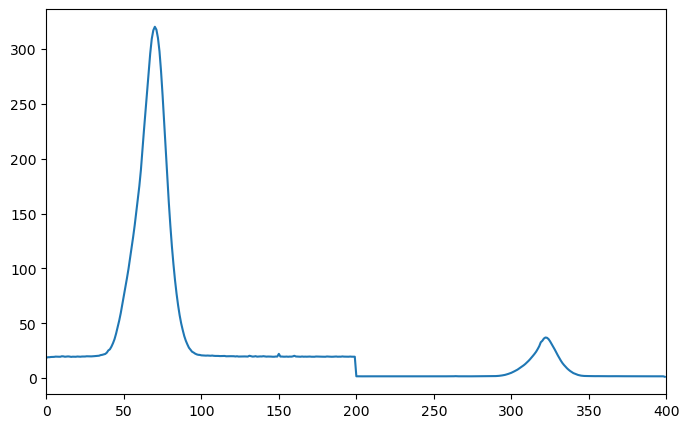

In [63]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(data.sum())
ax.set_xlim([0, 400])

intensity_sum = data.sum()
pixel_position_up = np.argmax(intensity_sum[0:200])
pixel_position_dw = np.argmax(intensity_sum[200:400])
print(f"The max intensity position (up): {pixel_position_up}")
print(f"The max intensity position (dw): {pixel_position_dw+200}")

In [64]:
data.sum()

0      18.666805
1      19.172065
2      19.157134
3      19.374492
4      19.402645
         ...    
395     1.773900
396     1.759012
397     1.751931
398     1.759626
399     1.331846
Length: 400, dtype: float64

122
img copied on cripboard !!


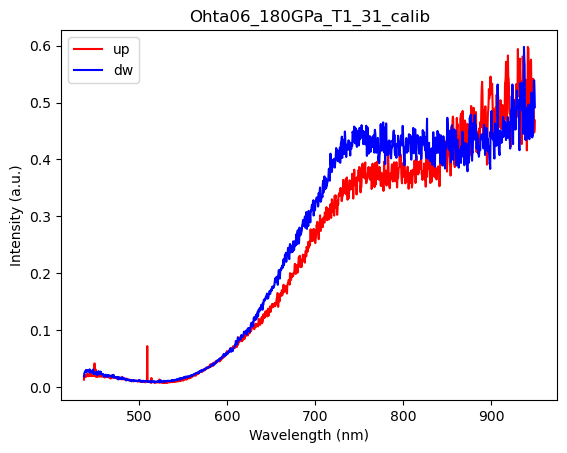

In [65]:
import os
import matplotlib.pyplot as plt
from io import BytesIO
from PIL import Image
import AppKit  # pyobjcをインポート



spectrum_up = data.iloc[:, pixel_position_up]
spectrum_dw = data.iloc[:, pixel_position_dw+200]
print(pixel_position_dw)
up_max = spectrum_up.max()
dw_max = spectrum_dw.max()
mag_rate = up_max / dw_max

wl_arr = spe_file.xaxis

spectrum = data.iloc[:, 330]
# plt.plot(wl_arr, spectrum*mag_rate, color='green')

plt.plot(wl_arr, spectrum_up, color='red', label='up')
plt.plot(wl_arr, spectrum_dw*mag_rate, color='blue', label='dw')
plt.title(f'{file_name}')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity (a.u.)')
plt.legend()

buf = BytesIO()

# 図をバッファーに保存
plt.savefig(buf, format='png')
buf.seek(0)

# バッファーからPillowのImageオブジェクトに変換
img = Image.open(buf)

# バッファーの内容をクリップボードにコピー
def copy_image_to_clipboard(image):
    # Pillow の Image を PNG 形式で保存してクリップボードにコピー
    output = BytesIO()
    image.save(output, "PNG")
    data = output.getvalue()

    # macOSのクリップボードにアクセスして画像をコピー
    ns_image = AppKit.NSImage.alloc().initWithData_(AppKit.NSData.dataWithBytes_length_(data, len(data)))
    pb = AppKit.NSPasteboard.generalPasteboard()
    pb.clearContents()
    pb.writeObjects_([ns_image])

# 画像をクリップボードにコピー
citc = copy_image_to_clipboard(img)


print('img copied on cripboard !!')


In [39]:
# DataFrameを作成
test_spectrum = {
    'Wavelength': wl_arr,
    'Spectrum_Up': spectrum_up,
    'Spectrum_Dw': [dw * mag_rate for dw in spectrum_dw]
}

df_test = pd.DataFrame(test_spectrum)

# CSVファイルとして出力
csv_file_path = f"/Users/nagayayoshihiro/project/IXS/IXS_Fe/rawdata/csv/spectrum_data_{file_name}.csv"
df_test.to_csv(csv_file_path, index=False)

In [495]:
spectrum = data.iloc[:, 330]
plt.plot

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

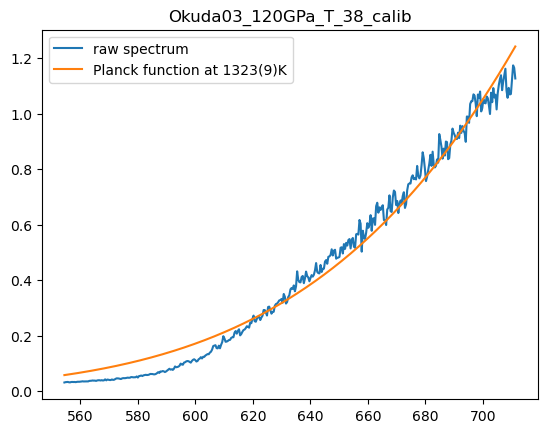

In [498]:
spectrum = spectrum_up
window = [295, 700]

wl_arr = spe_file.xaxis
wls = wavelength[window[0]:window[1]]
spectrums = spectrum[window[0]:window[1]]

results = planck_fit(wls, spectrums)

T = results[0]
scale = results[1]
T_err = results[2]
scale_err = results[3]

I_calc = planck_function(wls, T, scale)

plt.plot(wls, spectrums, label='raw spectrum')
plt.plot(wls, I_calc, label=f'Planck function at {T:.0f}({T_err:.0f})K')
plt.title(f'{file_name}')
plt.legend()

/Users/nagayayoshihiro/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 600.

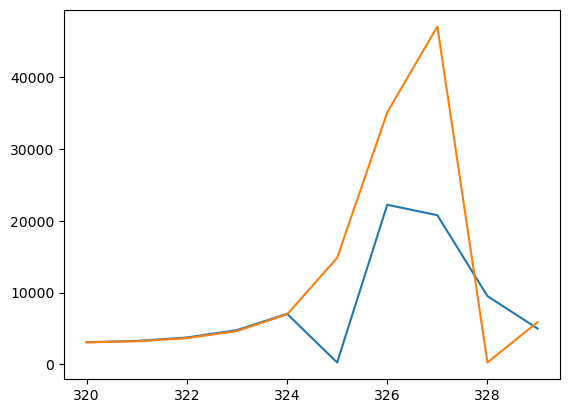

In [368]:
column_list = list(range(320, 330))
cmap = plt.get_cmap('jet')

file_path = '/Volumes/Ohta_ssd/Nagaya/IXS/2210/2022Oct19_T_Hirose/2022Oct19_T_Hirose/Okuda03_120GPa/calib/bef'
files = os.listdir(file_path)
for file in files:
    spe_file = SpeFile(os.path.join(file_path, file))
    data_2d = np.squeeze(spe_file.data)
    data = pd.DataFrame(data_2d)
    
    window = [425, 950]
    wl_arr = spe_file.xaxis
    wls = wavelength[window[0]:window[1]]
    T_dist=[]
    for i, column in enumerate(column_list):
        spectrum = data.iloc[:, column]
        spectrums = spectrum[window[0]:window[1]]
        results = planck_fit(wls, spectrums)

        T = results[0]
        scale = results[1]
        T_err = results[2]
        scale_err = results[3]
        T_dist.append(T)
        color = cmap(i / len(column_list))
#         plt.plot(spectrums, color=color)
#         plt.xlim([400,700])
#         plt.ylim([-0.001, 0.004])
#     plt.show()
        
    plt.plot(column_list, T_dist)
plt.xlabel('pixcel')
plt.ylabel('Temperature (K)')
# plt.ylim([1150, 1400])



    

0.5771592687221082


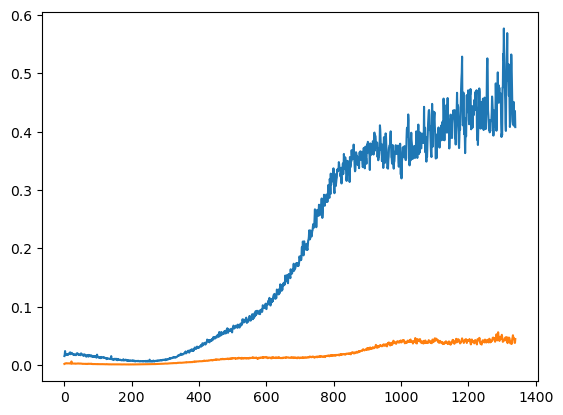

In [30]:
spectrum1 = data.iloc[:, 67]
spectrum2 = data.iloc[:, 328]
print(spectrum1.max())
plt.plot(spectrum1)
plt.plot(spectrum2)
# plt.ylim([-0.01, 0.015])

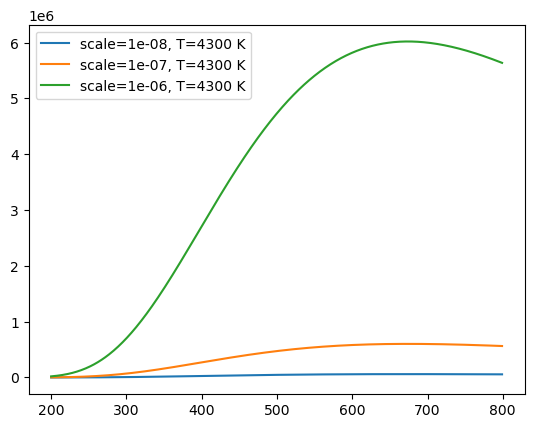

In [96]:
T_arr = [4300]
scale_arr = [1e-8, 1e-7, 1e-6]
wls = list(range(200, 800))

for T in T_arr:
    for scale in scale_arr:
        I = planck_function(wls, T, scale)
        plt.plot(wls, I, label=f'scale={scale}, T={T} K')
        
# T_ex=1200
# scale_ex=2e-7
# I_ex = planck_function(wls, T_ex, scale_ex)
# plt.plot(wls, I, label=f'scale={scale_ex}, T={T_ex} K')
plt.legend()
# plt.ylim([0, 700])

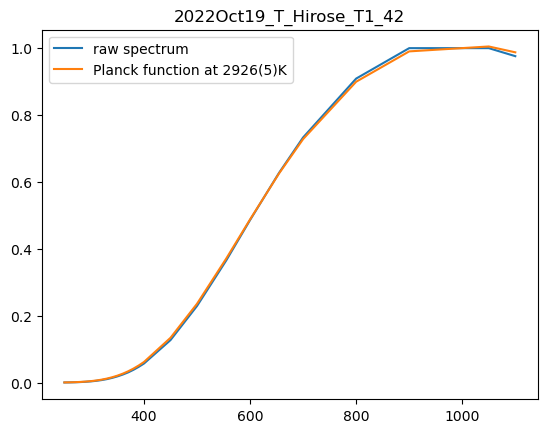

In [57]:
import pandas as pd

lamp_data = '/Volumes/Ohta_ssd/Nagaya/IXS/OL245_I1087-2.csv'
data = pd.read_csv(lamp_data, header=None)

# 1列目をlamp_wls_arr、2列目をlamp_int_arrとして定義
lamp_wls_arr = data.iloc[:, 0]
lamp_int_arr = data.iloc[:, 1]

# window = [600, 800]
# wls = wavelength[window[0]:window[1]]
# spectrums = spectrum[window[0]:window[1]]

lamp_wls = lamp_wls_arr
lamp_int = lamp_int_arr 

results = planck_fit(lamp_wls, lamp_int)

T = results[0]
scale = results[1]
T_err = results[2]
scale_err = results[3]

lamp_I_calc = planck_function(lamp_wls, T, scale)

plt.plot(lamp_wls, lamp_int, label='raw spectrum')
plt.plot(lamp_wls, lamp_I_calc, label=f'Planck function at {T:.0f}({T_err:.0f})K')
plt.title(f'{file_name}')
plt.legend()